#LSTM for Sentiment Analysis

##Import Data

In [1]:
import kagglehub

path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

100%|██████████| 25.7M/25.7M [00:00<00:00, 77.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1


In [2]:
import os
import shutil

if os.path.exists(path):
    for filename in os.listdir(path):
        if filename == "IMDB Dataset.csv":
            source_file = os.path.join(path, filename)
            destination_file = os.path.join(os.getcwd(), filename)

            try:
                shutil.copy2(source_file, destination_file) # copy2 preserves metadata (timestamp etc.)
                print(f"File '{filename}' downloaded successfully to {destination_file}")
            except Exception as e:
                print(f"Error downloading file '{filename}': {e}")
else:
    print(f"The path '{path}' does not exist.")


File 'IMDB Dataset.csv' downloaded successfully to /content/IMDB Dataset.csv


In [3]:
import pandas as pd

df = pd.read_csv('IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


##Data Preprocessing

In [4]:
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import string
import warnings
warnings.filterwarnings("ignore")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


###Remove Data Missing

In [6]:
df.isnull().sum()

,0
review,0
sentiment,0


Tidak ada data missing dalam dataset

###Remove Data Duplicate

In [7]:
df.duplicated().sum()

418

terdapat 418 data yang terduplikasi dalam dataset sehingga akan kita hapus

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


Setelah menghapus data duplicate, sekarang terdapat 49582 data tersisa

###Check Class Ratio

In [10]:
positive_count = df[df['sentiment'] == 'positive'].shape[0]
negative_count = df[df['sentiment'] == 'negative'].shape[0]

total_count = positive_count + negative_count

ratio = positive_count / total_count

print(f"Total number of reviews: {total_count}")
print(f"Number of positive reviews: {positive_count}")
print(f"Number of negative reviews: {negative_count}")

Total number of reviews: 49582
Number of positive reviews: 24884
Number of negative reviews: 24698


Data kedua kelas *Seimbang* sehingga tidak diperlukan perlakuan khusus

###Clean Review Data Text

In [11]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Terlihat ada data yang memiliki tag html sehingga perlu dibersihkan dahulu, selain itu kita akan membersihkan speciial character.

###Remove HTML Tags

In [12]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

df["review"] = df["review"].apply(remove_html_tags)

###Remove Punctuation

In [13]:
punctuation_pattern = f"[{string.punctuation}]"
df["review"] = df["review"].str.replace(punctuation_pattern, "", regex=True)

###Remove Double or More Spaces

Mengecek apakah ada data dengan spasi berlebih

In [14]:
reviews_with_multiple_spaces = df[df['review'].str.contains(r'\s{2,}')]
reviews_with_multiple_spaces

,review,sentiment
3,Basically theres a family where a little boy J...,negative
7,This show was an amazing fresh innovative ide...,negative
8,Encouraged by the positive comments about this...,negative
18,I remember this filmit was the first film i ha...,positive
19,An awful film It must have been up against som...,negative
...,...,...
49982,To be hones I used to like this show and watch...,negative
49983,I loved it having been a fan of the original s...,positive
49989,I got this one a few weeks ago and love it Its...,positive
49997,I am a Catholic taught in parochial elementary...,negative


Terdapat banyak data dengan space berlebih, oleh karena itu akan kita bersihkan agar spasi yang digunakan tidak berlebihan

####Delete Multiple Space

In [15]:
df["review"] = df["review"].str.replace("\s+", " ", regex=True).str.strip()

In [16]:
reviews_with_multiple_spaces = df[df['review'].str.contains(r'\s{2,}')]
reviews_with_multiple_spaces

,review,sentiment


###Remove Stopwords

In [17]:
import nltk
from nltk.corpus import stopwords
import string
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
df["review"] = df["review"].apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


###lowercasing review

In [18]:
df["review"] = df["review"].str.lower()
df

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought wonderful way spend time hot summer ...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive
...,...,...
49995,i thought movie right good job it wasnt creati...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,i catholic taught parochial elementary schools...,negative
49998,im going disagree previous comment side maltin...,negative


##Build Bidirectional LSTM

###Import Library

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

###Split Dataset

Data kemudian dibagi menjadi 4 bagian yaitu : train_sentences, test_sentences, train_labels, test_labels

In [28]:
reviews = df['review'].values
labels = df['sentiment'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, encoded_labels, stratify = encoded_labels)

###Hyperparameter

In [138]:
# Hyperparameters of the model
vocab_size = 4000
oov_tok = ''
embedding_dim = 120
max_length = 180
padding_type='post'
trunc_type='post'

Setelah percobaan berkali-kali, akan digunakan vocab_size 4000, oov_token ' ', embedding_dim 120, max_length 100, dengan padding type 'post' dan trunc_type 'post'.

###Tokenize

Proses Tokenize menggunakan tokenizer dimana data diubah menjadi token

In [139]:
# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

###Build LSTM Model

####Use rmsprop Optimizer

In [168]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
# model summary
model.summary()

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_39 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_39 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

####Use adam Optimizer

In [177]:
model2 = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model summary
model2.summary()

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_42 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_42 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

###Training

Setelah melakukan beberapa kali percobaan, Epoch optimal untuk model LSTM dengan rmsprop optimizer dalam proses ini adalah 4.

In [170]:
num_epochs = 4

# early_stopping = EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)

history = model.fit(train_padded, train_labels, epochs=num_epochs, batch_size=64, validation_split=0.2,  verbose=1)

prediction = model.predict(test_padded)
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(test_labels,pred_labels))

Epoch 1/4
465/465 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.6386 - loss: 0.6065 - val_accuracy: 0.8478 - val_loss: 0.3556
Epoch 2/4
465/465 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8539 - loss: 0.3586 - val_accuracy: 0.8561 - val_loss: 0.3555
Epoch 3/4
465/465 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8812 - loss: 0.2977 - val_accuracy: 0.8829 - val_loss: 0.2980
Epoch 4/4
465/465 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8974 - loss: 0.2611 - val_accuracy: 0.8852 - val_loss: 0.2870
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Accuracy of prediction on test set :  0.8822200709906421


Setelah melakukan beberapa kali percobaan, Epoch optimal untuk model LSTM dengan adam optimizer dalam proses ini adalah 3.

In [178]:
num_epochs = 3
# early_stopping = EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)

history2 = model2.fit(train_padded, train_labels, epochs=num_epochs, batch_size=64, validation_split=0.2,  verbose=1)

prediction = model2.predict(test_padded)
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(test_labels,pred_labels))

Epoch 1/3
465/465 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.7287 - loss: 0.5095 - val_accuracy: 0.8762 - val_loss: 0.3024
Epoch 2/3
465/465 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8892 - loss: 0.2788 - val_accuracy: 0.8818 - val_loss: 0.2872
Epoch 3/3
465/465 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9099 - loss: 0.2248 - val_accuracy: 0.8791 - val_loss: 0.2972
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Accuracy of prediction on test set :  0.8758470474346564


###Visualize the Result

Berikut merupakan visualisasi darii proses training dan validation dengan metrik accuracy.

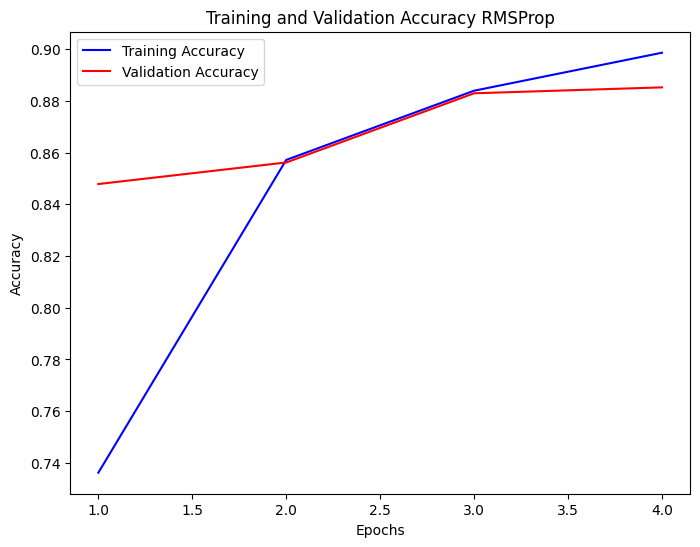

In [172]:
import matplotlib.pyplot as plt

# Ekstrak data dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy RMSProp')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

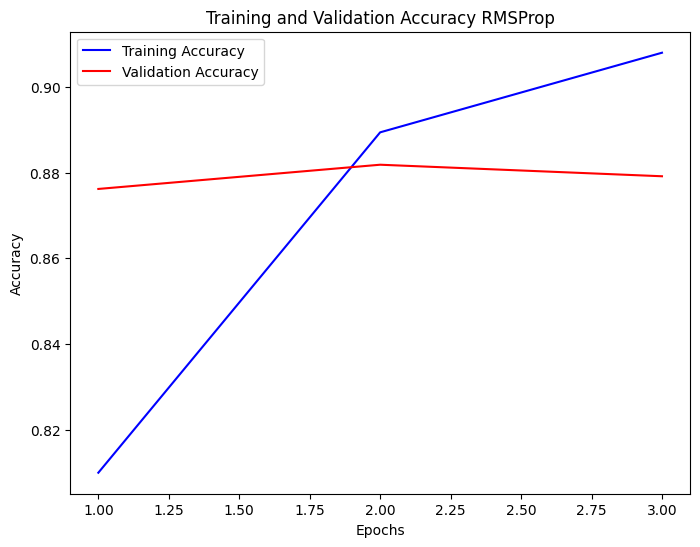

In [179]:
import matplotlib.pyplot as plt

# Ekstrak data dari history
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy RMSProp')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###Test the Model

In [180]:
sentence = ["The movie was very touching and heart whelming",
            "I have never seen a terrible movie like this",
            "the movie plot is terrible but it had good acting",
            "The cinematography was stunning, but the storyline was lacking and unoriginal.",
            "The film was a masterpiece with a perfect blend of drama and action, a must-watch!",
            "I love the movie but, it's very terrible"]

# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)
# pad the sequence
padded = pad_sequences(sequences, padding='post', maxlen=max_length)

prediction = model.predict(padded)
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
for i in range(len(sentence)):
    print(sentence[i])
    if pred_labels[i] == 1:
        s = 'Positive'
    else:
        s = 'Negative'
    print("Predicted sentiment : ",s)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
The movie was very touching and heart whelming
Predicted sentiment :  Positive
I have never seen a terrible movie like this
Predicted sentiment :  Negative
the movie plot is terrible but it had good acting
Predicted sentiment :  Negative
The cinematography was stunning, but the storyline was lacking and unoriginal.
Predicted sentiment :  Negative
The film was a masterpiece with a perfect blend of drama and action, a must-watch!
Predicted sentiment :  Positive
I love the movie but, it's very terrible
Predicted sentiment :  Negative


##Conclusion

Model dengan rmsprop optimizer mendapatkan sekitar 89% accuracy pada proses training dan sekitar 88% pada proses testing/validation sementara Model dengan adam optimizer mendapatkan sekitar 95% accuracy pada proses training dan sekitar 87% pada proses testing/validation. Dari berbagai hasil yang saya temukan dari notebook orang lain pada Kaggle menunjukan hasil yang serupa. Kemungkinan terdapat bias pada dataset. Kalimat dengan komentar neutral cendrung diprediksi negative oleh model seperti kalimat "the movie plot is terrible but it had good acting" yang diprediksi negative. Overall, model ini sudah cukup baik dalam menganalisis sentimen.